# Monotonic splines

In [1]:
from IPython import get_ipython

if get_ipython():
    get_ipython().run_line_magic("load_ext", "autoreload")
    get_ipython().run_line_magic("autoreload", "2")

import numpy as np
import pandas as pd
import torch

import xarray as xr

import matplotlib.pyplot as plt
import seaborn as sns

import collections

import latenta as la

In [2]:
cells = la.Dim(pd.Series(range(100), name="cell").astype(str))
genes = la.Dim(pd.Series(range(4), name="gene").astype(str))
knots = la.Dim(range(10), "knot")

## Generative model

In [3]:
n_cells = 100
cell_ids = [str(i) for i in range(n_cells)]
cells = la.Dim(pd.Series(cell_ids, name="cell"))

x = la.Fixed(pd.Series(np.random.uniform(0, 20, n_cells), index=cells.index), label="x")

In [4]:
# MONOTONIC GS
n_knots = 10

knots = la.Dim(range(n_knots), name="knot")

n_genes = 4
steps = np.concatenate([
    np.concatenate([np.random.normal(3.0, 1.0, (2))[:, None] * np.ones((2, 1)), -np.zeros((2, n_knots - 1))], 1),
    np.random.choice([-1, 1], (n_genes))[:, None]
    * np.abs(np.random.normal(3.0, 1.0, (n_genes, n_knots)))
    * (np.random.random((n_genes, n_knots)) > 0.5),
    np.concatenate([np.ones((n_genes, int(np.floor(n_knots/2)))), -np.ones((n_genes, int(np.ceil(n_knots/2))))], 1)
    * np.abs(np.random.normal(3.0, 1.0, (n_genes, n_knots)))
    * (np.random.random((n_genes, n_knots)) > 0.5)
], 0)

n_genes = steps.shape[0]
genes = la.Dim([str(i) for i in range(n_genes)], name="gene")

a_value = steps.cumsum(1)
a_value = a_value - a_value.mean(1, keepdims=True)
a = la.Fixed(pd.DataFrame(a_value, columns=knots.index, index=genes.index), label="a")
intercept = la.Fixed(
    pd.Series(
        np.random.choice([-1, 1], n_genes)
        * np.random.normal(1., 1.0, n_genes)
        * (np.random.random(n_genes) > 0.5),
        index=genes.index,
    ),
    label="intercept",
)
y = la.links.scalar.Spline(x=x, a=a, b=intercept)

In [5]:
scale = la.Fixed(
    1.
#     pd.Series(np.random.uniform(1.0, 1.2, n_genes), index=genes.index), label="scale"
)
dist = la.distributions.Normal(loc=y, scale=scale, label="distribution")

In [6]:
model_gs = la.Root(dist = dist, label="ground truth", symbol="gs")
model_gs.plot()

In [7]:
posterior = la.posterior.Posterior(dist, retain_samples={dist.loc, dist})
posterior.sample(1)

  0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot:xlabel='gene', ylabel='cell'>

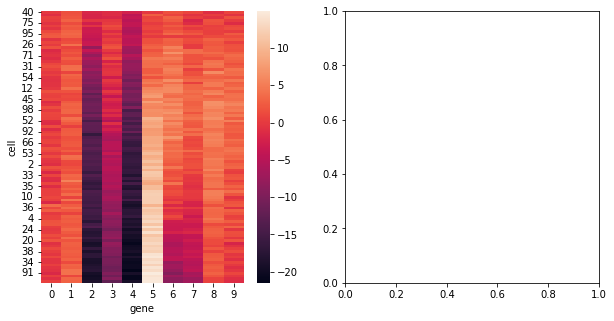

In [8]:
loc_value = posterior.samples[dist.loc].sel(sample=0).to_pandas()
observation_value = posterior.samples[dist].sel(sample=0).to_pandas()
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
cell_order = model_gs.find("x").prior_pd().sort_values().index
sns.heatmap(observation_value.loc[cell_order], ax=ax0)

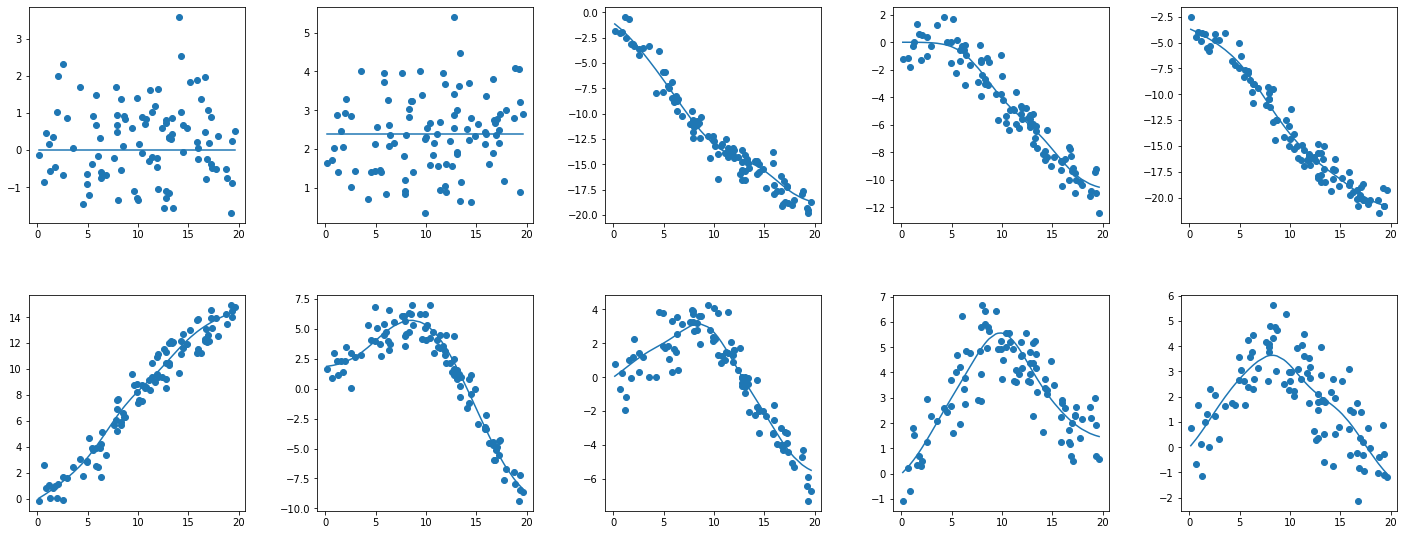

In [9]:
observation_value = posterior.samples[dist].sel(sample=0).to_pandas()
gene_ids = genes.coords[:10]
fig, axes = la.plotting.axes_wrap(len(gene_ids))
cell_order = model_gs.find("x").prior_pd().sort_values().index
x_value = model_gs.find("x").prior_pd()

for gene_id, ax in zip(gene_ids, axes):
    ax.scatter(x_value.loc[cell_order], observation_value.loc[cell_order, gene_id])
    ax.plot(x_value.loc[cell_order], loc_value.loc[cell_order, gene_id])
# sns.heatmap(observation_value.loc[cell_order], ax = ax0)

## Regression with variational inference

In [10]:
scale.reset()
intercept.reset()
y.reset()

loc: b, smoothness, a, knot, x ↦ Spline [cell (•), gene (•)] = $\sum_k \mathregular{ a }_k^T \cdot \phi(\mathregular{ smoothness } \cdot ||\mathregular{ x } - \mathregular{ knot }||_2) \mathregular{ where } \phi(x) = e^{x^2}\require{action}$

In [11]:
s = la.Parameter(1., transforms = [la.transforms.Exp()], definition = [genes])

z = la.links.scalar.MonotonicSpline(
    x, b=True, output=y.value_definition, label = "z"
)
# z.a.p.step.scale = la.Fixed(1.)
# z.a.p.sign.probs = la.Fixed(0.5)

dist = la.distributions.Normal(loc=z, scale=s)

observation = la.Observation(observation_value, dist, label="observation")

model_mspline = la.Root(observation = observation)
model_mspline.plot()

In [12]:
s = la.Parameter(1., transforms = [la.transforms.Exp()], definition = [genes])

z = la.links.scalar.Spline(
    x, b=True, output=y.value_definition, label = "z"
)
# z.a.p.step.scale = la.Fixed(1.)

dist = la.distributions.Normal(loc=z, scale=s)

observation = la.Observation(observation_value, dist, label="observation")

model_spline = la.Root(observation = observation)
model_spline.plot()

In [13]:
s = la.Parameter(1., transforms = [la.transforms.Exp()], definition = [genes])
# s = la.Fixed(1.)

z = la.links.scalar.Linear(
    x, a=True, b=True, output=y.value_definition, label = "z"
)
dist = la.distributions.Normal(loc=z, scale=s)

observation = la.Observation(observation_value, dist, label="observation")

model_linear = la.Root(observation = observation)
model_linear.plot()

In [14]:
models = {"linear":model_linear, "mspline":model_mspline, "spline":model_spline}
# models = {"mspline":model_mspline}

In [15]:
for model_id, model in models.items():
    print(model_id)
    inference = la.infer.svi.SVI(
        model, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr=0.01)
    )
    trainer = la.infer.trainer.Trainer(inference)
    trace = trainer.train(10000)
    trace.plot()

linear


  0%|                                                                                                         …

mspline


  0%|                                                                                                         …

spline


  0%|                                                                                                         …

In [16]:
for model_id, model in models.items():
    observed = la.posterior.vector.VectorObserved(
        model.observation, retain_samples=model.components_upstream().values()
    )
    observed.sample(30, subsample_n=1)
    model["observed"] = observed
    
    causal = la.posterior.scalar.ScalarVectorCausal(x, model.observation)
    causal.observed.sample()
    causal.sample(10)
    causal.sample_empirical()
    model["causal"] = causal

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [17]:
pd.Series({model_id:model["observed"].elbo.item() for model_id, model in models.items()})

linear    -1896.764678
mspline   -1737.681928
spline    -1645.391027
dtype: float64

In [18]:
likelihood_features = pd.DataFrame({model_id:model["observed"].likelihood_features.to_pandas() for model_id, model in models.items()})
likelihood_features.head(10).style.bar(axis = 1)

,linear,mspline,spline
gene,,,
0,-147.517517,-146.952393,-143.927124
1,-143.454437,-143.066711,-143.573257
2,-177.241592,-178.095856,-174.516754
3,-169.513000,-148.978912,-145.934723
4,-175.305161,-192.627853,-187.767929
5,-150.681595,-137.150986,-135.451279
6,-257.013214,-174.580322,-144.043915
7,-217.346893,-163.949173,-136.318970
8,-197.525558,-178.822998,-134.972656


In [19]:
elbo_features = pd.DataFrame({model_id:model["observed"].elbo_features.to_pandas() for model_id, model in models.items()})
elbo_features.head(10).style.bar(axis = 1)

,linear,mspline,spline
gene,,,
0,-152.276323,-155.573124,-156.449795
1,-149.176713,-153.940705,-155.981261
2,-184.723661,-185.850859,-187.473362
3,-175.651907,-157.552187,-160.925619
4,-182.626278,-201.401722,-199.932480
5,-157.282400,-149.269917,-151.655338
6,-262.286778,-189.353446,-163.597494
7,-222.663777,-172.705540,-152.413556
8,-202.719539,-187.948815,-149.199325


In [20]:
(likelihood_features - elbo_features).head(10).style.bar(axis = 1)

,linear,mspline,spline
gene,,,
0,4.758806,8.620731,12.522671
1,5.722276,10.873994,12.408004
2,7.482068,7.755004,12.956607
3,6.138906,8.573275,14.990896
4,7.321118,8.773869,12.164551
5,6.600806,12.118931,16.204059
6,5.273564,14.773124,19.553579
7,5.316884,8.756367,16.094587
8,5.193980,9.125817,14.226668


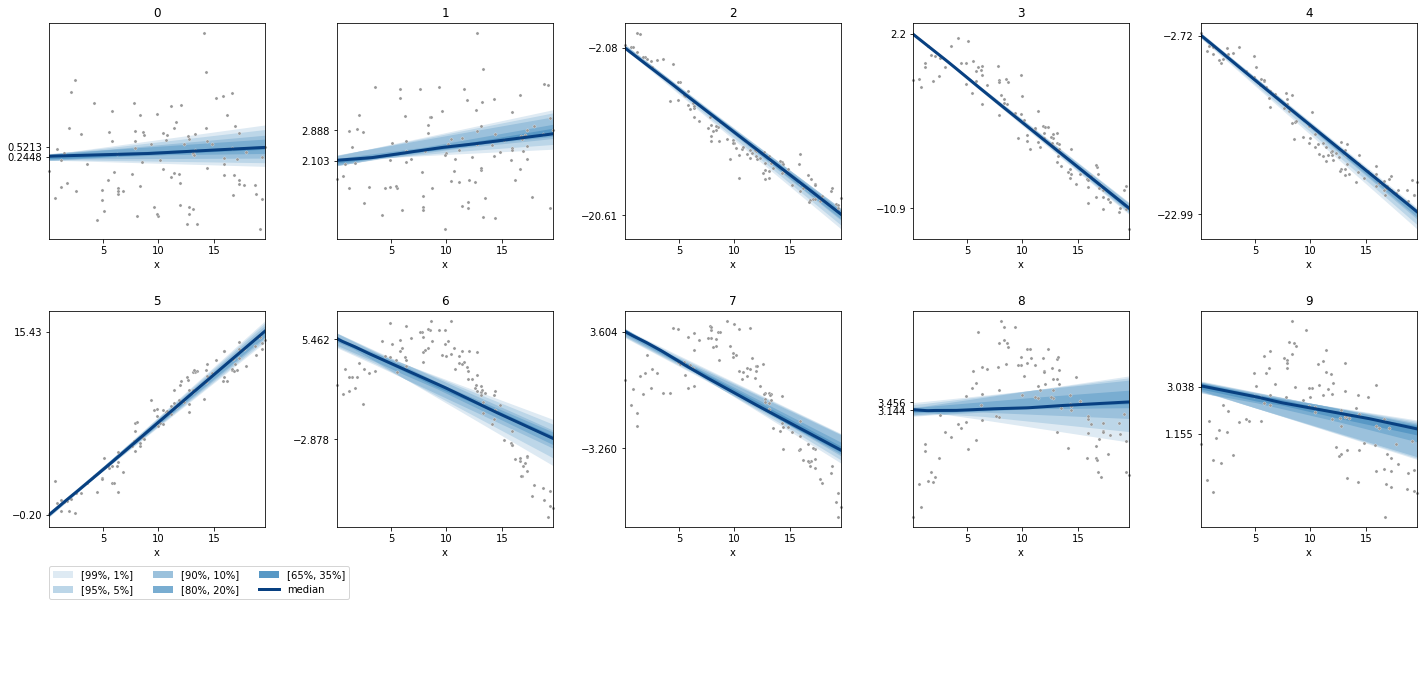

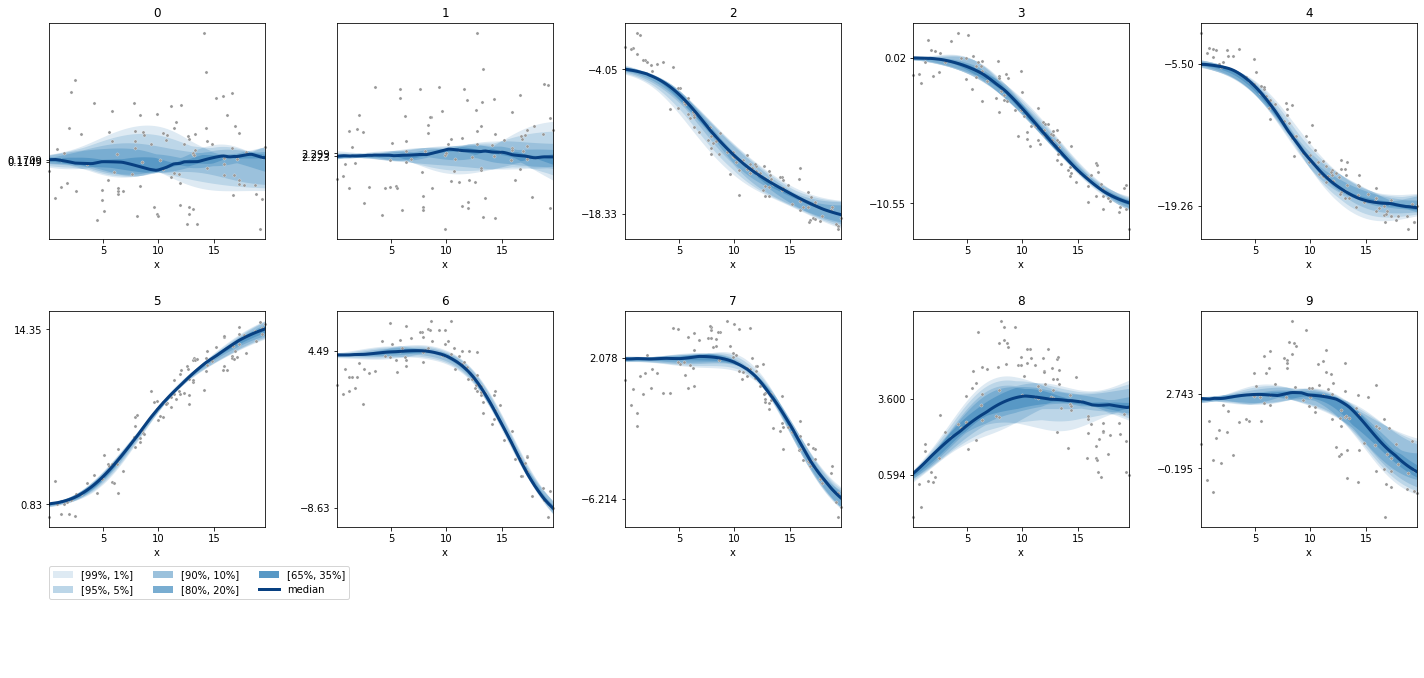

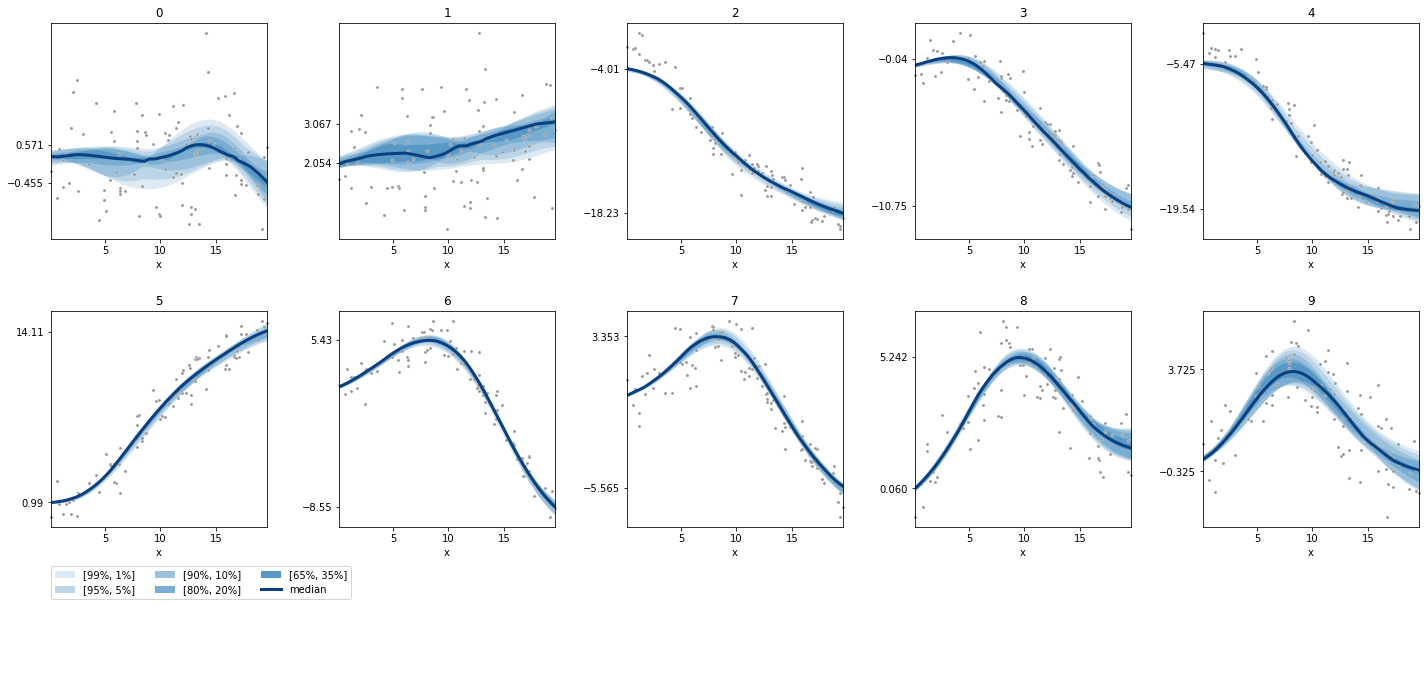

In [21]:
for model_id, model in models.items():
    causal = model["causal"]
    fig = causal.plot_features(show = True)